In [65]:
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.pyplot as mpimg

import utils
from regions.selectivesearch_answer import selective_search
# from regions.selectivesearch import selective_search

import chainer
from chainercv.links import FeaturePredictor
from chainercv.links import VGG16

%matplotlib inline

In [66]:
##############
# PARAMETERS #
##############

# MODEL PATH ON SERVER
# IF YOU ARE RUNNING LOCALLY YOU MUST EDIT THIS PATH!
MODEL_PATH = '/data/unagi0/dataset/rinkou/vgg16_imagenet_convert_2017_07_18.npz'

# SELECTIVE-SEARCH PARAMETERS
SS_PARAMS = {"SCALE": 250,
            "SIGMA": 0.9,
            "MIN_SIZE": 50,
            "MIN_REGION": 2000,
            "MAX_RATIO": 2}

IOU_THRESHOLD = 0.3

CONF_THRESHOLD = 0.5

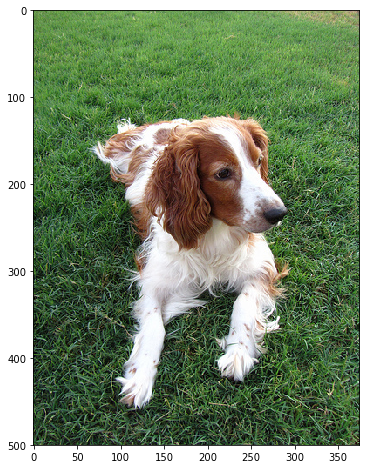

In [67]:
## Read and Display image
img = mpimg.imread("./test_images/ILSVRC2012_val_00018556.JPEG")
plt.figure(figsize=(8,8))
plt.imshow(img)

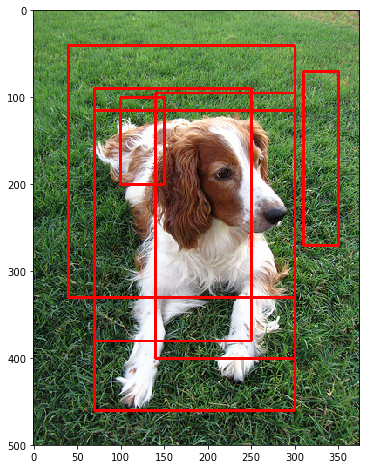

In [68]:
# Set up a image copy and some toy bbox/confidence examples
img_copy = img.copy()
bboxes = [[70,300,115,460], [70,250,90,380], [140,300,95,400], [100,150,100,200], [40,300,40,330],[310,350,70,270]]
confidences = [0.95, 0.7, 0.8, 0.6, 0.8, 0.3]

# Display bboxes
for bbox in bboxes:
    x1, x2, y1, y2 = bbox
    cv2.rectangle(img_copy, (x1, y1), (x2, y2), 0xFF3333, thickness=2)
    
plt.figure(figsize=(8,8))
plt.imshow(img_copy)

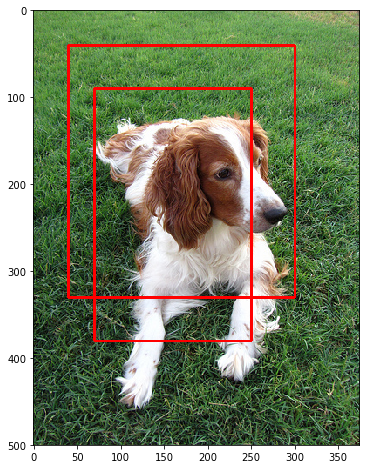

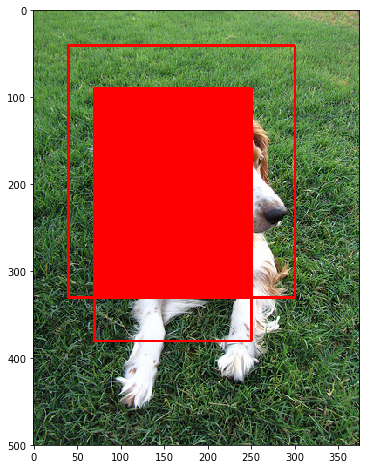

In [69]:
## TASK 1 ##
# FINDING THE INTERSECTION #
def get_overlap(boxA, boxB):
    A_x1, A_x2, A_y1, A_y2 = boxA
    B_x1, B_x2, B_y1, B_y2 = boxB
    
    ## TO BE COMPLETED
    ## overlap is a bounding box of form [x1, x2, y1, y2]
    
    x1 = max(A_x1, B_x1)
    y1 = max(A_y1, B_y1)
    x2 = min(A_x2, B_x2)
    y2 = min(A_y2, B_y2)
    
    ## IF THERE IS NO OVERLAP YOU SHOULD RETURN [0,0,0,0]
    if x1 >= x2 or y1 >= y2:
        overlap = [0,0,0,0]
    else:
        overlap = [x1,x2,y1,y2]
        
    return overlap

# sample randomle from bboxes
i, j = random.sample(range(6),2)
x1,x2,y1,y2 = get_overlap(bboxes[i], bboxes[j])

# plot the two bboxes
img_copy = img.copy()
cv2.rectangle(img_copy, (bboxes[i][0], bboxes[i][2]), (bboxes[i][1], bboxes[i][3]), 0xFF3333, thickness=2)
cv2.rectangle(img_copy, (bboxes[j][0], bboxes[j][2]), (bboxes[j][1], bboxes[j][3]), 0xFF3333, thickness=2)
plt.figure(figsize=(8,8))
plt.imshow(img_copy)

# fill in the intersection
cv2.rectangle(img_copy, (x1, y1), (x2, y2), 0x33FF33, thickness=-1)
plt.figure(figsize=(8,8))
plt.imshow(img_copy)

0.5523924894003635


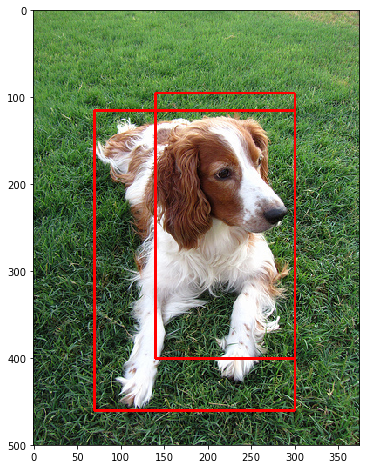

In [70]:
## TASK 2 ##
# FIND INTERSECTION OVER UNION - IOU #
def get_iou(boxA, boxB):
    overlap = get_overlap(boxA, boxB)
    
    A_x1, A_x2, A_y1, A_y2 = boxA
    B_x1, B_x2, B_y1, B_y2 = boxB
    O_x1, O_x2, O_y1, O_y2 = overlap
    
    ## FILL IN CALCULATION FOR IOU HERE ##
    boxA_area = (A_x2 - A_x1) * (A_y2 - A_y1)
    boxB_area = (B_x2 - B_x1) * (B_y2 - B_y1)
    overlap_area = (O_x2 - O_x1) * (O_y2 - O_y1)
    
    union_area = boxA_area + boxB_area - overlap_area
    iou = overlap_area / union_area
    
    return iou

# sample randomle from bboxes
i, j = random.sample(range(6),2)

# plot the two bboxes
img_copy = img.copy()
cv2.rectangle(img_copy, (bboxes[i][0], bboxes[i][2]), (bboxes[i][1], bboxes[i][3]), 0xFF3333, thickness=2)
cv2.rectangle(img_copy, (bboxes[j][0], bboxes[j][2]), (bboxes[j][1], bboxes[j][3]), 0xFF3333, thickness=2)
plt.figure(figsize=(8,8))
plt.imshow(img_copy)

print(get_iou(bboxes[i], bboxes[j]))

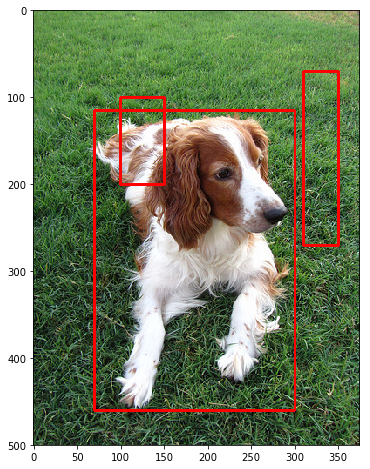

In [71]:
## TASK 3 ##
# NON MAX SUPRESSION #
def nms(bboxes, confidences, threshold):
    
    idxs = np.argsort(confidences)
    idxs = idxs[::-1]
    suppress = set()

    for i, idx_high_conf in enumerate(idxs):
        if idx_high_conf in suppress:
            continue
        for idx_low_conf in idxs[i+1:]:
            if idx_low_conf in suppress:
                continue
            
            iou = get_iou(bboxes[idx_high_conf], bboxes[idx_low_conf])
            if (iou > threshold):
                suppress.add(idx_low_conf)
    
    # Takes the set different between all indexes and suprressed indexes
    pick = set(range(len(bboxes))) - suppress
    
    return list(pick)

picks = nms(bboxes, confidences, 0.3)
img_copy = img.copy()
for pick in picks:
    bbox = bboxes[pick]
    cv2.rectangle(img_copy, (bbox[0], bbox[2]), (bbox[1], bbox[3]), 0xFF3333, thickness=2)
plt.figure(figsize=(8,8))
plt.imshow(img_copy)
    

In [72]:
## LETS TEST OUR CODE AND SEE IF IT WORKS ON SOME REAL EXAMPLES ##

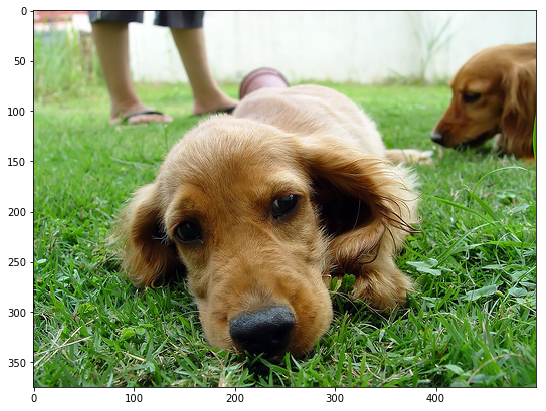

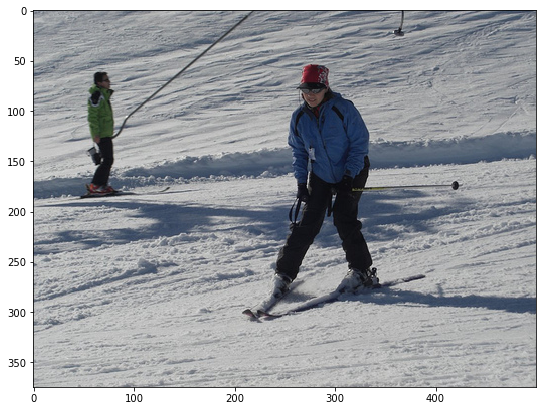

In [77]:
image_paths = ['./test_images/ILSVRC2012_val_00004995.JPEG', './test_images/ILSVRC2012_val_00046368.JPEG']
# Load and Display images
imgs = utils.get_images(image_paths, display=True)

CPU times: user 3 s, sys: 24.2 ms, total: 3.02 s
Wall time: 3.02 s


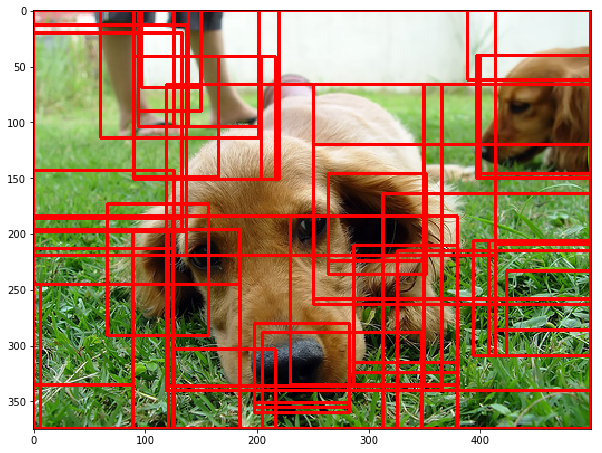

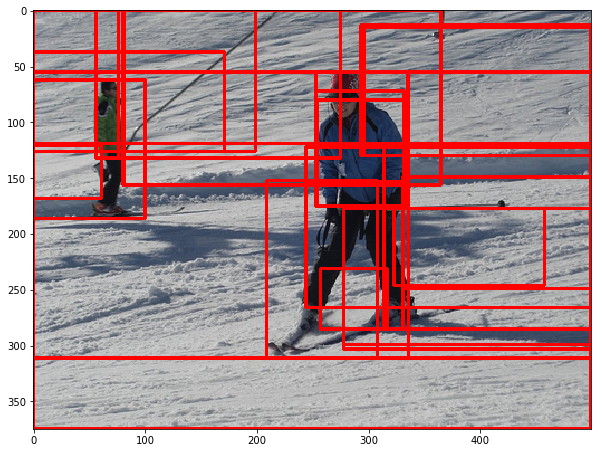

In [78]:
%%time
# Performs selective search using function "selective_search"
# perform_selectivesearch appends bboxes to img["bboxes"] and cropped regions to img["cropped_regions"]
utils.perform_selectivesearch(selective_search, imgs, SS_PARAMS)

In [ ]:
# Initialize VGG16 classifier model
extractor = VGG16(1000, MODEL_PATH)
model = FeaturePredictor(extractor, crop_size=224, scale_size=256, crop='center')


In [ ]:
%%time
# perform_classification appends class predictions to img["classes"] and confidences to img["confidences"]
utils.perform_classification(model, imgs)

In [ ]:
%%time
# Perform non maximum supression on bounding boxes. For regions havin an overlap exceeding the threshold
# The region with the lower confidence score will be suppressed
for img in imgs:
    img["selected_regions"] = nms(img["bboxes"], img["confidences"], IOU_THRESHOLD)

In [ ]:
# Display Detected Regions and Classes
utils.display_detections(imgs, CONF_THRESHOLD)